In [1]:
#rcParams['savefig.dpi'] = 75

#from mpl_toolkits.basemap import Basemap
%matplotlib inline
from matplotlib.pylab import *
import numpy as np

from sigvisa import Sigvisa
from sigvisa.source.event import get_event, Event
from sigvisa.signals.io import fetch_waveform, EventNotDetected, MissingWaveform
from sigvisa.signals.common import Waveform

from sigvisa.models.ttime import tt_predict

from sigvisa.graph.sigvisa_graph import SigvisaGraph
from sigvisa.infer.optimize.optim_utils import construct_optim_params
from sigvisa.plotting.plot import plot_det_times, plot_pred_atimes
from sigvisa.database.dataset import read_evids_detected_at_station, read_event_detections, DET_TIME_COL

from sigvisa.graph.load_sigvisa_graph import load_sg_from_db_fit
from sigvisa.models.wiggles.wavelets import construct_full_basis_implicit

In [21]:
sg = SigvisaGraph(wiggle_family='db4_2.0_3_20.0', 
                  template_shape="lin_polyexp",
                  phases=['Pg',], 
                  wiggle_model_type="gplocal+lld+none",
                  template_model_type="gpparam",
                  min_mb=1.0,
                  raw_signals=True,
                 runids=(18,))



srate=10.0
w = Waveform(np.zeros((int(srate*40),)), srate=srate, stime=1243212800.0, sta="ELK", chan="BHZ")
wf = w.filter("freq_0.8_4.5")
wn = sg.add_wave(wf, fixed=False)


ev = Event(lon=-114.0, lat=41.0, mb=1.7, depth=0.0, time=wn.st - 15 )
sg.add_event(ev, fixed=True)

np.random.seed(6)
sg.parent_sample_all()

sampling w/ seed 898214035


In [53]:
print wn.arrivals()
print wn.get_template_params_for_arrival(1, "Pg")

nodes = sg.get_template_nodes(1, wn.sta, "Pg", wn.band, wn.chan)
nodes["coda_height"][1].set_value(4.5)
nodes["coda_decay"][1].set_value(-2.0)
nodes["peak_decay"][1].set_value(-1.0)
nodes["peak_offset"][1].set_value(0.0)
nodes["arrival_time"][1].set_value(1243212805)
wn.parent_sample()

set([(1, 'Pg')])
({'coda_height': 4.499999999999999, 'arrival_time': 1243212805.0, 'coda_decay': -2.0, 'peak_decay': -1.0, 'peak_offset': 0.0}, <sigvisa.models.templates.lin_polyexp.LinPolyExpTemplateGenerator object at 0x7fc2f61c09d0>)
sampling w/ seed 907388218


reading station detections... 


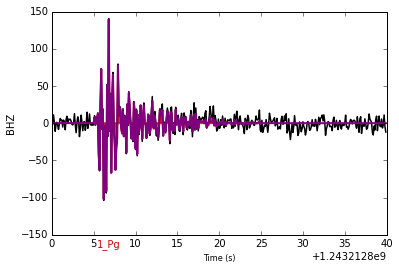

In [54]:
wn.plot(ax=gca())

(1243212804.0, 1243212820.0)

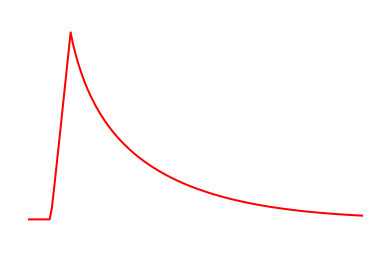

In [55]:
def plot_bare(data, x, ax=None, **kwargs):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
    ax.axis('off')
    ax.plot(x, data, **kwargs)
    return ax


#d = wn.get_value()
wn.tssm = wn.transient_ssm()
#lp1, marginals, step_ells = wn.tssm.all_filtered_cssm_coef_marginals(d)
#posterior_means, posterior_vars = marginals[2]
cssm = wn.arrival_ssms[(1, "Pg")]

ncoefs = len(wn.wavelet_param_models["Pg"])
prior_means, prior_vars = np.zeros((ncoefs,)), np.ones((ncoefs,))
cssm.set_coef_prior(prior_means, prior_vars)

#prior_means, prior_vars = np.zeros(posterior_means.shape), np.ones(posterior_vars.shape)
#cssm.set_coef_prior(prior_means, prior_vars)
template = wn.tssm.obs_var(wn.npts)
template = np.sqrt(template)
x = np.linspace(wn.st, wn.et, wn.npts)

ax = plot_bare(template, x, color="red", linewidth=2)
ax.set_xlim([wn.st+4, wn.st+20])

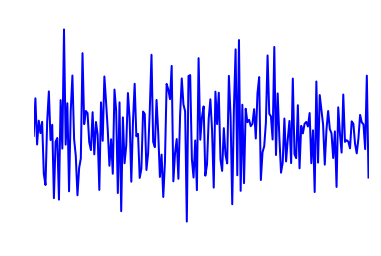

In [56]:



d = wn.get_value()
lp1, marginals, step_ells = wn.tssm.all_filtered_cssm_coef_marginals(d)
posterior_means, posterior_vars = marginals[1]
cssm = wn.arrival_ssms[(1, "Pg")]
cssm.set_coef_prior(posterior_means, posterior_vars)

wiggle = cssm.mean_obs(200)
ax = plot_bare(wiggle, np.linspace(0, 20, 200), color="blue", linewidth=2)



(1243212802.0, 1243212825.0)

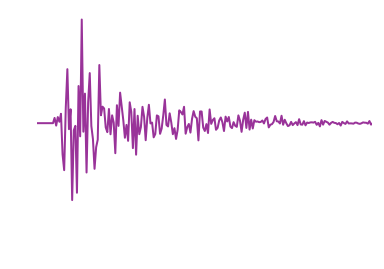

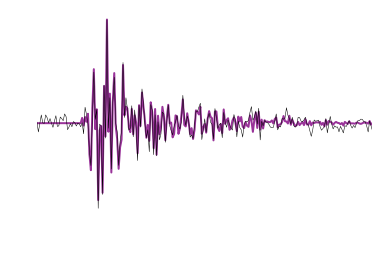

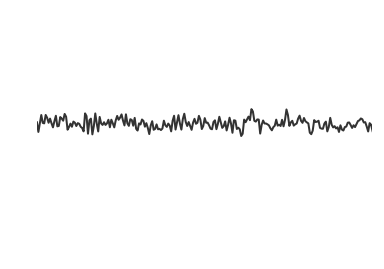

In [57]:
pred_signal = wn.tssm.mean_obs(wn.npts)
noise = wn.nm.sample(len(pred_signal))
ss = pred_signal+noise

ax = plot_bare(pred_signal, x, color="purple", linewidth=2, alpha=0.8)
ax.set_xlim([wn.st+4, wn.st+25])

ax = plot_bare(pred_signal, x, color="purple", linewidth=2, alpha=0.8)
ax.plot(x, ss, color="black", linewidth=0.5)
ax.set_xlim([wn.st+2, wn.st+25])

f = plt.figure()
ax = f.add_subplot(111, sharey=ax)
plot_bare(noise, x, color="black", linewidth=2, alpha=0.8, ax=ax)
ax.set_xlim([wn.st+2, wn.st+25])
